In [1]:
import re
import tweepy
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tweepy import OAuthHandler
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [3]:
MY_BEARER_TOKEN = "Bearer Token From twitter API"
client = tweepy.Client(bearer_token=MY_BEARER_TOKEN)

In [6]:
keyword="lockdown"
noOfTweets=100
query = "@narendramodi lang:en -is:retweet"
tweets = client.search_recent_tweets(query=query,tweet_fields = ["text", "source"],max_results = noOfTweets)

In [7]:
print(len(tweets.data))

100


In [8]:
first_tweet = tweets.data[1]
dict(first_tweet)

{'id': 1493884534881861632,
 'source': 'Twitter for Android',
 'text': '@DeeEternalOpt @PMOIndia @narendramodi If the vaccine does not protect themselves, how will it protect others?\n\nVaccine, health, medicines should not be used for politics. Keep the decisions related to it in hands of proper experts like immunologists or virologists..\n\nPoliticians and politics should be kept miles away'}

In [9]:
def clean(str):
    s1=re.sub('@\w+: '," ",str)
    s1=re.sub('\n'," ",s1)
    s1=re.sub('&amp;',"and",s1)
    s1=re.sub(r"https:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})", "", s1)
    return s1.lower()

In [10]:
polarity = 0
tweet_info_list=[]
for tweet in tweets.data:
 analysis = TextBlob(tweet.text)
 score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
 polarity += analysis.sentiment.polarity
 tweet_info = {
        'id':tweet.id,
        'text':clean(tweet.text),
        'source': tweet.source,
        'polarity':polarity,
        'neg': score['neg'],
        'neu': score['neu'],
        'pos': score['pos'],
    }
 tweet_info_list.append(tweet_info)

In [11]:
tweet_info_list[1]

{'id': 1493884534881861632,
 'text': '@deeeternalopt @pmoindia @narendramodi if the vaccine does not protect themselves, how will it protect others?  vaccine, health, medicines should not be used for politics. keep the decisions related to it in hands of proper experts like immunologists or virologists..  politicians and politics should be kept miles away',
 'source': 'Twitter for Android',
 'polarity': 0.0,
 'neg': 0.086,
 'neu': 0.865,
 'pos': 0.049}

In [12]:
positive = 0
negative = 0
neutral = 0
neutral_list = []
negative_list = []
positive_list = []
for t in tweet_info_list:
    if t["neg"] > t["pos"]:
     negative_list.append(t["text"])
     negative += 1
    elif t["pos"] > t["neg"]:
     positive_list.append(t["text"])
     positive += 1
    elif t["pos"] == t["neg"]:
     neutral_list.append(t["text"])
     neutral += 1

In [13]:
def percentage(part,whole):
 p=100 * float(part)/float(whole)
 return "("+str(p)+")%" 

In [14]:
print("Positive Tweetes : ",positive,percentage(positive,noOfTweets))
print("Neutral Tweetes : ",neutral,percentage(neutral,noOfTweets))
print("Negative Tweetes : ",negative,percentage(negative,noOfTweets))

Positive Tweetes :  49 (49.0)%
Neutral Tweetes :  30 (30.0)%
Negative Tweetes :  21 (21.0)%


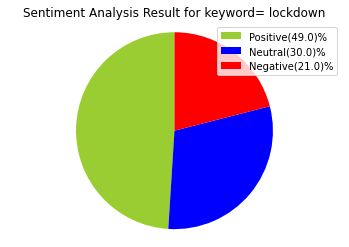

In [15]:
labels = ["Positive"+percentage(positive,noOfTweets) , "Neutral"+percentage(neutral,noOfTweets),"Negative"+percentage(negative,noOfTweets)]
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.title("Sentiment Analysis Result for keyword= "+keyword+"" )
plt.legend(labels)
plt.axis("equal")
plt.show()

In [16]:
def create_wordcloud(text):
 stopwords = set(STOPWORDS)
 wc = WordCloud(background_color="white",width = 900, height = 500,
 max_words=400,
 stopwords=stopwords,
 repeat=True)
 wc.generate(str(text))
 wc.to_file("word_cloud.png")
 path="word_cloud.png"
 display(Image.open(path))

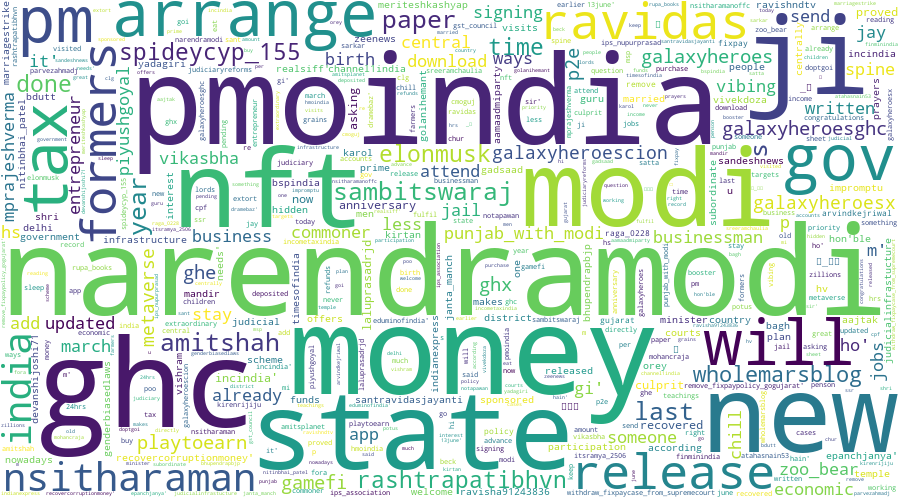

In [17]:
create_wordcloud(neutral_list)

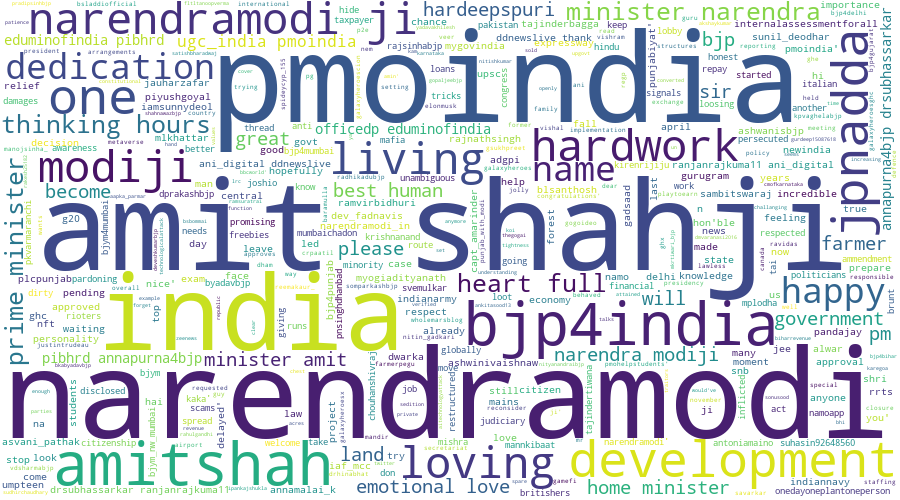

In [18]:
create_wordcloud(positive_list)

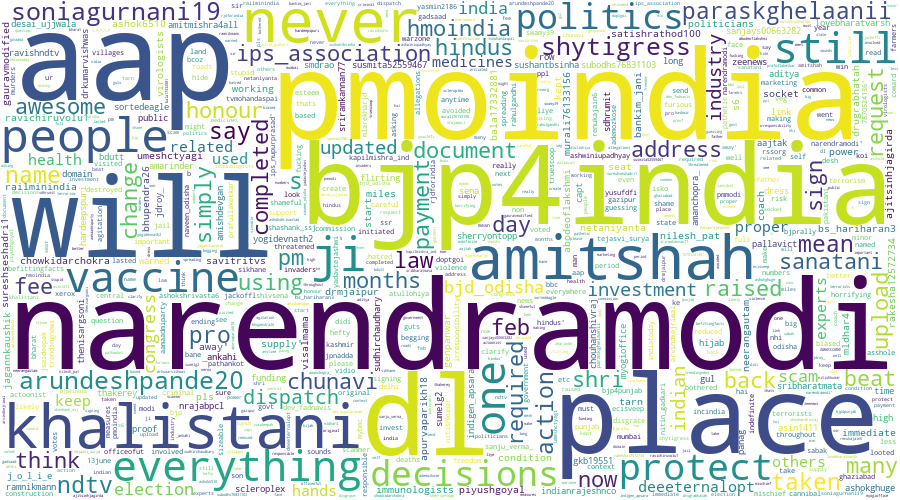

In [19]:
create_wordcloud(negative_list)

In [20]:
tweet_list=pd.DataFrame(tweet_info_list)

In [21]:
tweet_list['text_len'] = tweet_list['text'].astype(str).apply(len)
tweet_list['text_word_count'] = tweet_list['text'].apply(lambda x: len(str(x).split()))

In [22]:
for index, row in tweet_list.iterrows():
     if row['neg'] > row['pos']:
         tweet_list.loc[index, 'sentiment'] = "negative"
     elif row['pos'] > row['neg']:
         tweet_list.loc[index, 'sentiment'] = "positive"
     else:
         tweet_list.loc[index, 'sentiment'] = "neutral"

In [23]:
tweet_list.head(5)

,id,text,source,polarity,neg,neu,pos,text_len,text_word_count,sentiment
0,1493884547200872448,@zoo_bear @vikasbha @narendramodi someone hs a...,Twitter for Android,0.00,0.000,1.000,0.000,94,15,neutral
1,1493884534881861632,@deeeternalopt @pmoindia @narendramodi if the ...,Twitter for Android,0.00,0.086,0.865,0.049,319,47,negative
2,1493884532151390208,@narendramodi @ashwinivaishnaw @mlkhattar @har...,Twitter for Android,0.25,0.102,0.767,0.131,277,39,positive
3,1493884527353159681,@asvani_pathak @tajinderbagga @narendramodi he...,Twitter for iPhone,0.95,0.000,0.622,0.378,113,15,positive
4,1493884517689532417,@jauharzafar that he is. true @narendramodi @p...,Twitter for Android,1.30,0.000,0.682,0.318,53,7,positive


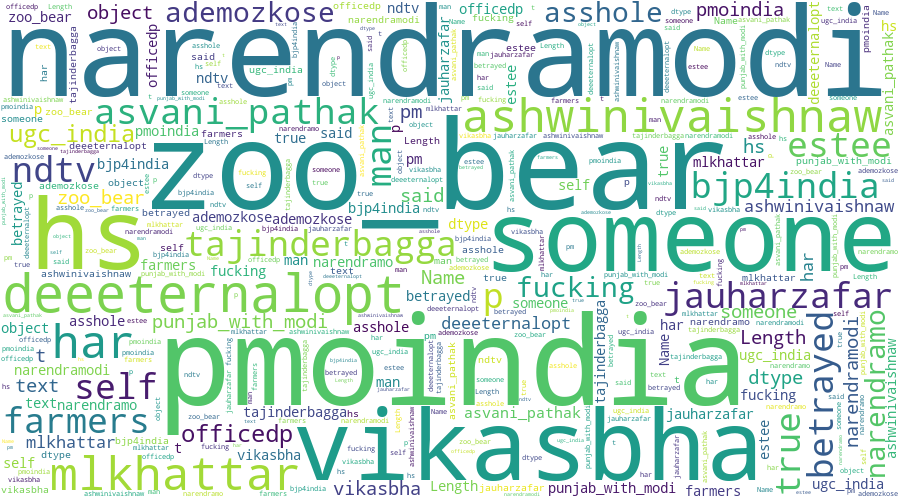

In [24]:
create_wordcloud(tweet_list.text)

In [25]:
def count_values_in_column(data,feature):
 total=data.loc[:,feature].value_counts(dropna=False)
 percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
 return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

count_values_in_column(tweet_list,"sentiment")

,Total,Percentage
positive,49,49.0
neutral,30,30.0
negative,21,21.0


In [26]:
round(pd.DataFrame(tweet_list.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,265.05
neutral,127.27
positive,205.76


In [27]:
round(pd.DataFrame(tweet_list.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,36.76
neutral,16.47
positive,27.47


<AxesSubplot:ylabel='Frequency'>

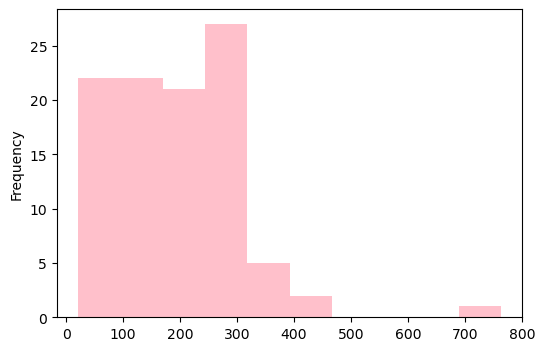

In [28]:
tweet_list.text_len.plot.hist(color = 'pink', figsize = (6, 4))

<AxesSubplot:ylabel='Frequency'>

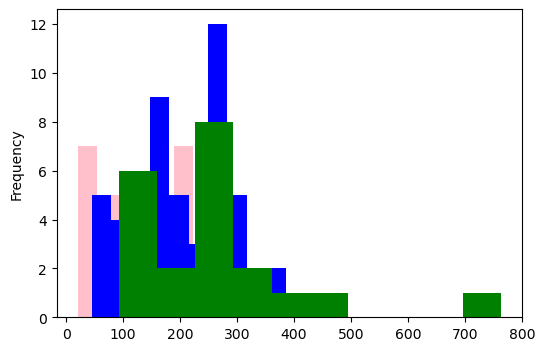

In [29]:
tweet_list[tweet_list["sentiment"]=="neutral"].text_len.plot.hist(color = 'pink', figsize = (6, 4))
tweet_list[tweet_list["sentiment"]=="positive"].text_len.plot.hist(color = 'blue', figsize = (6, 4))
tweet_list[tweet_list["sentiment"]=="negative"].text_len.plot.hist(color = 'green', figsize = (6, 4))

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

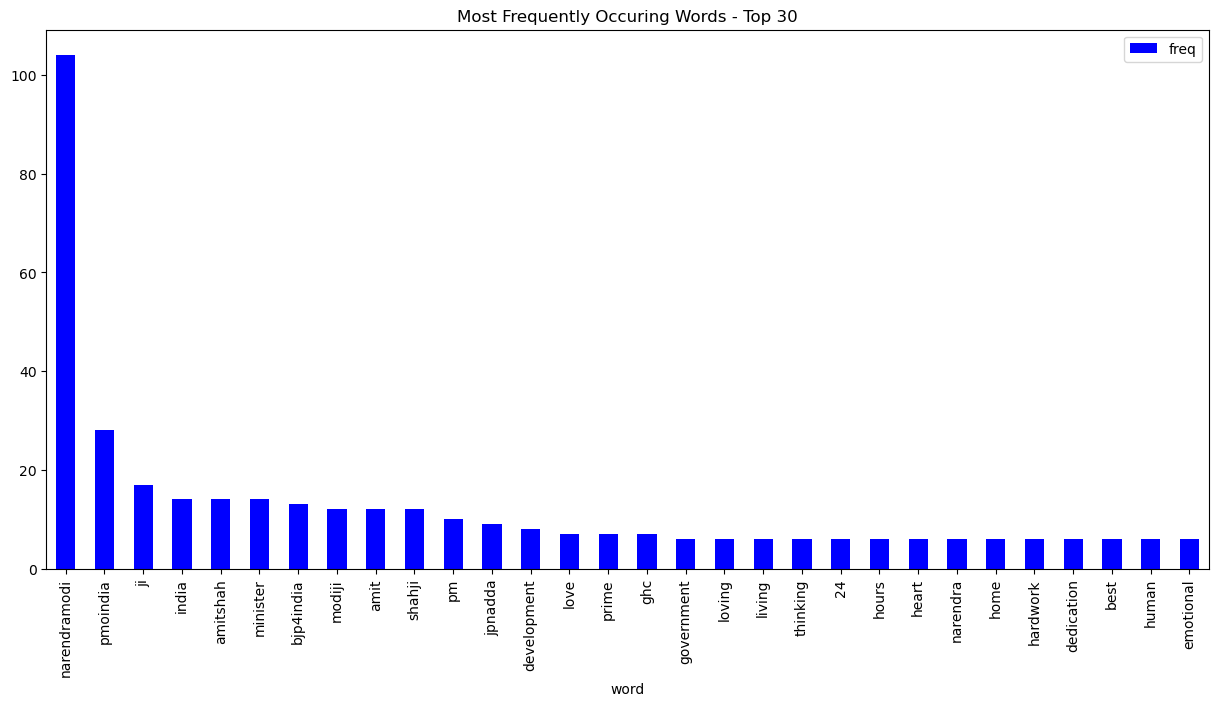

In [30]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(tweet_list.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")